In [ ]:
""" File for stitching together 2d images (.png) and saving as 3d volumes (.npy) """

In [50]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import re
import tqdm

# img_dir = "data/small_data_2d/original"
img_dir="/Volumes/LaCie/bigdata/imgs"
# mask_dir = "data/small_data_2d/ground_truth"
mask_dir="/Volumes/LaCie/bigdata/gts"
# subdirs = ["train", "valid", "test"]
cell_mask_dir="/Volumes/LaCie/bigdata/masks"

In [51]:
def get_z_y_x(file_name, pattern):
    """ get z, y, x from file name (uses basename of file_name)"""
    file_name = os.path.basename(file_name)
    match = re.match(pattern, file_name)
    if match:
        if len(match.groups()) != 3:
            return None
        z, y, x = match.groups()
        return int(z), int(y), int(x)
    else:
        return None
    
def get_img_by_coords(z, y, x, img_files, img_pattern):
    """ get path of image by z, y, x """
    for i in range(len(img_files)):
        img_file = img_files[i]
        try:
            z_, y_, x_ = get_z_y_x(img_file, img_pattern)
        except:
            continue
        if z == z_ and y == y_ and x == x_:
            return cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    return None

def get_3d_slice_single_img(z,y,x, img_files, img_pattern, depth=1, width=512, height=512):
    img_3d = np.zeros((2*depth+1, width, height))
    for i in range(-depth, depth+1):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        if img is not None:
            img_3d[i+depth] = img
    return img_3d

def get_3d_slice(z,y,x, img_files, mask_files, img_pattern, mask_pattern, depth=1, width=512, height=512):
    """ get 3d slice by z, y, x 
    
    -think of the original image as 3d volume, and each slice is a pixel
    -so we want a column of pixels, with the center pixel being the pixel at z, y, x, and sliding up and down along the z axis
    
    Args:
        z: int, z coordinate
        y: int, y coordinate
        x: int, x coordinate
        img_files: list of str, paths to images
        mask_files: list of str, paths to masks
        img_pattern: str, pattern to extract z, y, x from image file name
        mask_pattern: str, pattern to extract z, y, x from mask file name
        depth: int, how many slices to include above and below the center slice
        width: int, width of each slice
        height: int, height of each slice
    """
    img_3d = np.zeros((2*depth+1, width, height))
    mask_3d = np.zeros((2*depth+1, width, height))
    for i in range(-depth, depth+1):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        mask = get_img_by_coords(z_coord, y, x, mask_files, mask_pattern)
        if img is not None and mask is not None:
            img_3d[i+depth] = img
            mask_3d[i+depth] = mask
    return img_3d, mask_3d

def get_3d_slice_forward(z,y,x, img_files, mask_files, img_pattern, mask_pattern, depth=3, width=512, height=512):
    """ get 3d slice by z, y, x 
    
    -think of the original image as 3d volume, and each slice is a pixel
    -so we want a column of pixels, with the center pixel being the pixel at z, y, x, and sliding up and down along the z axis
    
    Args:
        z: int, z coordinate
        y: int, y coordinate
        x: int, x coordinate
        img_files: list of str, paths to images
        mask_files: list of str, paths to masks
        img_pattern: str, pattern to extract z, y, x from image file name
        mask_pattern: str, pattern to extract z, y, x from mask file name
        depth: int, how many slices to include above and below the center slice
        width: int, width of each slice
        height: int, height of each slice
    """
    img_3d = np.zeros((depth, width, height))
    mask_3d = np.zeros((depth, width, height))
    for i in range(depth):
        z_coord = z+i
        img = get_img_by_coords(z_coord, y, x, img_files, img_pattern)
        mask = get_img_by_coords(z_coord, y, x, mask_files, mask_pattern)
        if img is not None and mask is not None:
            img_3d[i] = img
            mask_3d[i] = mask
    return img_3d, mask_3d

In [52]:
# sort the files by z, y, x (ensure that img and mask files are in the same order)
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)
cell_mask_files = os.listdir(cell_mask_dir)
mask_pattern=r"sem2dauer_gj_2d_training.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png.png"
img_pattern=r"SEM_dauer_2_image_export_s(\d+)_Y(\d+)_X(\d+).png.png"
cell_mask_pattern=r"20240325_SEM_dauer_2_nr_vnc_neurons_head_muscles.vsseg_export_s(\d+)_Y(\d+)_X(\d+).png"
img_files = [os.path.join(img_dir, f) for f in img_files if f.endswith(".png")]
mask_files = [os.path.join(mask_dir, f) for f in mask_files if f.endswith(".png")]
cell_mask_files = [os.path.join(cell_mask_dir, f) for f in cell_mask_files if f.endswith(".png")]
print(img_files[:10])
print(mask_files[:10])
print(cell_mask_files[:10])

['/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s001_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s001_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s014_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s014_Y8_X13.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s034_Y3_X9.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s034_Y3_X9.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s010_Y7_X5.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s010_Y7_X5.png.png', '/Volumes/LaCie/bigdata/imgs/SEM_dauer_2_image_export_s006_Y7_X9.png.png', '/Volumes/LaCie/bigdata/imgs/._SEM_dauer_2_image_export_s006_Y7_X9.png.png']
['/Volumes/LaCie/bigdata/gts/sem2dauer_gj_2d_training.vsseg_export_s043_Y14_X9.png.png', '/Volumes/LaCie/bigdata/gts/._sem2dauer_gj_2d_training.vsseg_export_s043_Y14_X9.png.png', '/Volumes/LaCie/bigdata/gts/sem2dauer_gj_2d_training.vss

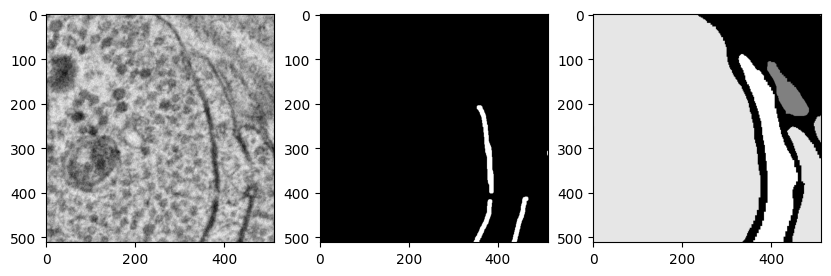

In [53]:
# sanity check: test that image and mask actually match
num = 20
z,y,x= get_z_y_x(img_files[num].split('/')[-1], img_pattern)
tmp_img = get_img_by_coords(z, y, x, img_files, img_pattern)
tmp_mask = get_img_by_coords(z, y, x, mask_files, mask_pattern)
tmp_cell_mask = get_img_by_coords(z, y, x, cell_mask_files, cell_mask_pattern)
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(tmp_img, cmap='gray')
ax[1].imshow(tmp_mask, cmap='gray')
ax[2].imshow(tmp_cell_mask, cmap='gray')

(3, 512, 512) (3, 512, 512) (3, 512, 512)


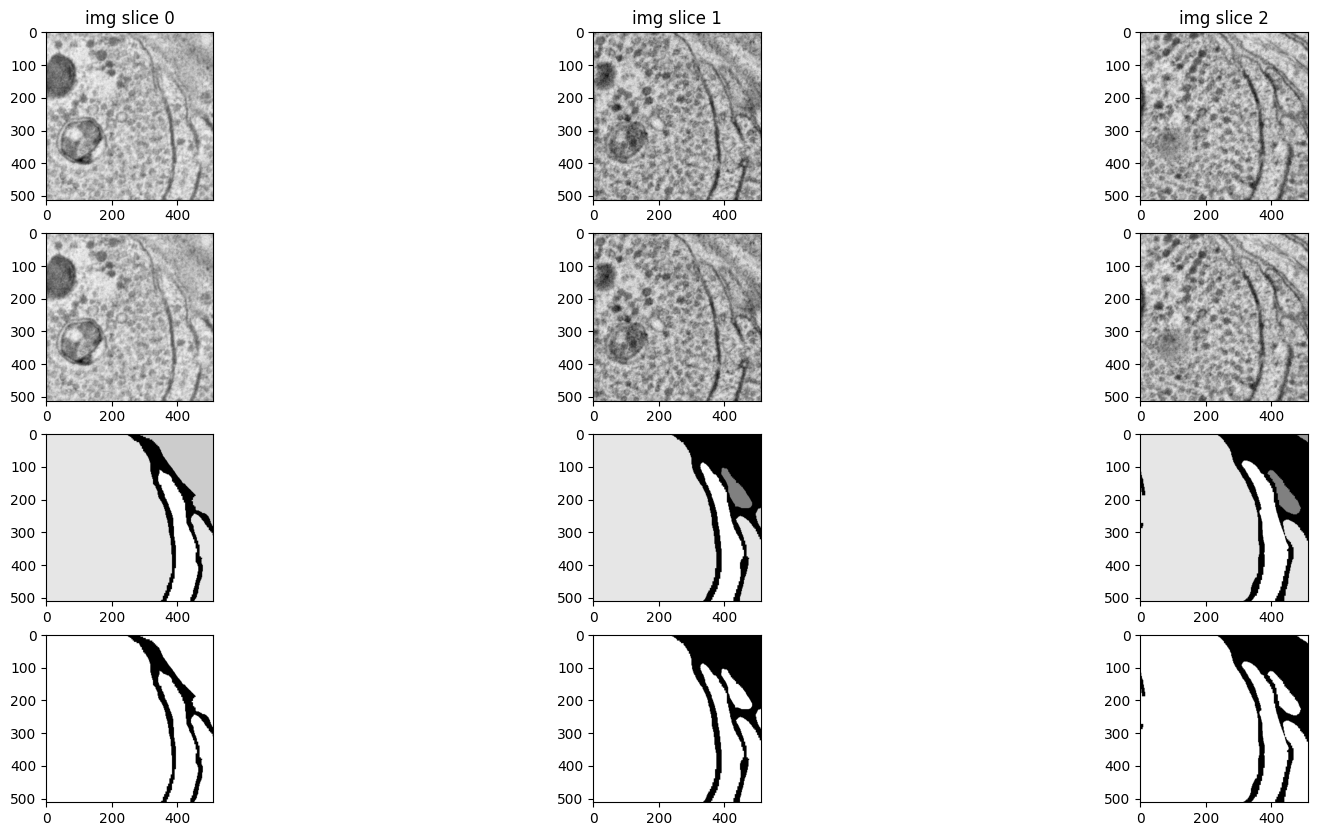

In [57]:
# 3d slice sanity check
depth = 1
img_3d = get_3d_slice_single_img(z, y, x, img_files, img_pattern, depth=depth)
mask_3d = get_3d_slice_single_img(z, y, x, mask_files, mask_pattern, depth=depth)
cell_mask_3d = get_3d_slice_single_img(z, y, x, cell_mask_files, cell_mask_pattern, depth=depth)
filtered_cell_mask_3d = cell_mask_3d.copy()
filtered_cell_mask_3d[filtered_cell_mask_3d!=0]=1
img_3d= img_3d.astype(np.uint8)
combined
print(img_3d.shape, mask_3d.shape, cell_mask_3d.shape)
depth=2*depth+1
fig, ax = plt.subplots(4, depth, figsize=(20, 10))
for i in range(depth):
    ax[0, i].imshow(img_3d[i], cmap='gray')
    ax[1, i].imshow(mask_3d[i], cmap='gray')
    ax[2, i].imshow(cell_mask_3d[i], cmap='gray')
    ax[3, i].imshow(filtered_cell_mask_3d[i], cmap='gray')
    ax[0, i].set_title(f"img slice {i}")
plt.show()

In [54]:
print(len(img_files), len(mask_files))

5390 5390


In [64]:
save_dir = "/Volumes/LaCie/membrane_select_data_512"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
if not os.path.exists(os.path.join(save_dir, "original")):
    os.makedirs(os.path.join(save_dir, "original"))
if not os.path.exists(os.path.join(save_dir, "ground_truth")):
    os.makedirs(os.path.join(save_dir, "ground_truth"))

In [61]:
# save 3d slices
depth = 1 # (5, 512, 512)
# total = len(img_files)
total=2
for i in range(total):
    try:
        z, y, x = get_z_y_x(img_files[i], img_pattern)
    except:
        continue
    try:
        img_3d = get_3d_slice_single_img(z, y, x, img_files, img_pattern, depth=depth)
        mask_3d = get_3d_slice_single_img(z, y, x, mask_files, mask_pattern, depth=depth)
        cell_mask_3d = get_3d_slice_single_img(z, y, x, cell_mask_files, cell_mask_pattern, depth=depth)
        filtered_cell_mask_3d = cell_mask_3d.copy()
        filtered_cell_mask_3d[filtered_cell_mask_3d!=0]=1
    except:
        print(f"no 3d slice available for {z}{y}{x}")
        continue
    img_3d = img_3d.astype(np.uint8)
    mask_3d = mask_3d.astype(np.uint8)
    filtered_cell_mask_3d = filtered_cell_mask_3d.astype(np.uint8)
    if i == 0:
        print(img_3d.shape, mask_3d.shape)
    np.save(os.path.join(save_dir, "original", f"z{z}_y{y}_x{x}.npy"), img_3d)
    np.save(os.path.join(save_dir, "ground_truth", f"z{z}_y{y}_x{x}.npy"), mask_3d)

(3, 512, 512) (3, 512, 512)


In [62]:
files = os.listdir(os.path.join(save_dir, "original"))
print(len(files)) # 243 training samples (some may overlap a bit, fine for now)

2695


# Train Test Split

In [76]:
# data_dir = "data/small_data_512" # CHANGE ME
data_dir = "/Volumes/LaCie/dauer_data_512"

# load data
img_dir = os.path.join(data_dir, "original")
mask_dir = os.path.join(data_dir, "ground_truth")
img_paths = os.listdir(img_dir)
mask_paths = os.listdir(mask_dir)
imgs = [np.load(os.path.join(img_dir, img_path)) for img_path in img_paths if img_path.endswith(".npy")]
masks = [np.load(os.path.join(mask_dir, mask_path)) for mask_path in mask_paths if mask_path.endswith(".npy")]

In [77]:
# create subdirectories for train, valid, test
if not os.path.exists(os.path.join(img_dir, "train")):
    os.makedirs(os.path.join(img_dir, "train"))
if not os.path.exists(os.path.join(img_dir, "valid")):
    os.makedirs(os.path.join(img_dir, "valid"))
if not os.path.exists(os.path.join(img_dir, "test")):
    os.makedirs(os.path.join(img_dir, "test"))   
if not os.path.exists(os.path.join(mask_dir, "train")):
    os.makedirs(os.path.join(mask_dir, "train"))
if not os.path.exists(os.path.join(mask_dir, "valid")):
    os.makedirs(os.path.join(mask_dir, "valid"))
if not os.path.exists(os.path.join(mask_dir, "test")):
    os.makedirs(os.path.join(mask_dir, "test"))

In [79]:
# split data into train, valid, test
num_imgs = len(imgs)
indices = np.arange(num_imgs)
np.random.shuffle(indices)
train_indices = indices[:int(0.8*num_imgs)]
valid_indices = indices[int(0.8*num_imgs):int(0.9*num_imgs)]
test_indices = indices[int(0.9*num_imgs):]
print(len(train_indices), len(valid_indices), len(test_indices))
imgs = np.array(imgs)
masks = np.array(masks)
print("imgs shape: ", imgs.shape)

2156 269 270
imgs shape:  (2695, 3, 512, 512)


In [80]:
train_imgs = imgs[train_indices]
valid_imgs = imgs[valid_indices]
test_imgs = imgs[test_indices]

train_masks = masks[train_indices]
valid_masks = masks[valid_indices]
test_masks = masks[test_indices]
print(f"Train: {train_masks.shape}, {train_imgs.shape}") # (num_imgs, 512, 512, 3)
print(f"Valid: {valid_masks.shape}, {valid_imgs.shape}")
print(f"Test: {test_masks.shape}, {test_imgs.shape}")

Train: (2156, 3, 512, 512), (2156, 3, 512, 512)
Valid: (269, 3, 512, 512), (269, 3, 512, 512)
Test: (270, 3, 512, 512), (270, 3, 512, 512)


In [ ]:
# save imgs
for i,img in tqdm.tqdm(enumerate(train_imgs)):
    np.save(os.path.join(img_dir, "train", f"{i}.npy"), train_imgs[i])
    print(f"Saved train {i}")
for i,img in tqdm.tqdm(enumerate(valid_imgs)):
    np.save(os.path.join(img_dir, "valid", f"{i}.npy"), valid_imgs[i])
    print(f"Saved valid {i}")
for i,img in tqdm.tqdm(enumerate(test_imgs)):
    np.save(os.path.join(img_dir, "test", f"{i}.npy"), test_imgs[i])
    print(f"Saved test {i}")

# save masks
for i,mask in tqdm.tqdm(enumerate(train_masks)):
    np.save(os.path.join(mask_dir, "train", f"{i}.npy"), train_masks[i])
    print(f"Saved train {i}")
for i,mask in tqdm.tqdm(enumerate(valid_masks)):
    np.save(os.path.join(mask_dir, "valid", f"{i}.npy"), valid_masks[i])
    print(f"Saved valid {i}")
for i,mask in tqdm.tqdm(enumerate(test_masks)):
    np.save(os.path.join(mask_dir, "test", f"{i}.npy"), test_masks[i])
    print(f"Saved test {i}")

print("Done")

# Slice Data (smaller images)

In [1]:
""" Section one 512 x 512 image into sixteen 128 x 128 tiles."""

' Section one 512 x 512 image into sixteen 128 x 128 tiles.'

In [84]:
import os

old_dir = "/Volumes/LaCie/dauer_data_512"
new_dir = "/Volumes/LaCie/dauer_data_128"

# directory with the original images (full size)
old_img_dir = os.path.join(old_dir, "original")
old_mask_dir = os.path.join(old_dir, "ground_truth")
# directory to save the new images (small size)
new_img_dir = os.path.join(new_dir, "original")
new_mask_dir = os.path.join(new_dir, "ground_truth")

In [85]:
# Create new directories as needed
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
if not os.path.exists(new_img_dir):
    os.makedirs(new_img_dir)
if not os.path.exists(new_img_dir + "/train"):
    os.makedirs(new_img_dir + "/train")
if not os.path.exists(new_img_dir + "/test"):
    os.makedirs(new_img_dir + "/test")
if not os.path.exists(new_img_dir + "/valid"):
    os.makedirs(new_img_dir + "/valid")
if not os.path.exists(new_mask_dir):
    os.makedirs(new_mask_dir)
if not os.path.exists(new_mask_dir + "/train"):
    os.makedirs(new_mask_dir + "/train")
if not os.path.exists(new_mask_dir + "/test"):
    os.makedirs(new_mask_dir + "/test")
if not os.path.exists(new_mask_dir + "/valid"):
    os.makedirs(new_mask_dir + "/valid")

In [86]:
img_paths_train = os.listdir(old_img_dir + "/train")
mask_paths_train = os.listdir(old_mask_dir + "/train")
img_paths_test = os.listdir(old_img_dir + "/test")
mask_paths_test = os.listdir(old_mask_dir + "/test")
img_paths_valid = os.listdir(old_img_dir + "/valid")
img_paths_valid = os.listdir(old_mask_dir + "/valid")

print(len(img_paths_train), len(mask_paths_train), len(img_paths_test), len(mask_paths_test))

old_height = 512

# CHANGE ME
new_height = 128 # new height of each tile
# stride = 512 // new_height # stride to move the window
stride = 128
print(f"num new imgs: {old_height // stride}")

2156 2156 270 270
num new imgs: 4


In [87]:
import numpy as np

# train set
counter = 0 # for naming the new files
num_imgs = len(img_paths_train)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_train[k]
    img = np.load(old_img_dir + "/train/" + fp)
    mask = np.load(old_mask_dir + "/train/" + fp)
    
    # split the image into tiles
    for i in range(0, old_height, stride):
        for j in range(0, old_height, stride):
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            np.save(new_img_dir + "/train/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/train/" + str(counter) + ".npy", mask_tile)
            counter += 1

# test set
counter = 0
num_imgs = len(img_paths_test)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_test[k]
    img = np.load(old_img_dir + "/test/" + fp)
    mask = np.load(old_mask_dir + "/test/" + fp)
    
    for i in range(0, old_height, stride):
        for j in range(0, old_height, stride):
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            np.save(new_img_dir + "/test/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/test/" + str(counter) + ".npy", mask_tile)
            counter += 1

# valid set
counter = 0 
num_imgs = len(img_paths_valid)
for k in tqdm.tqdm(range(num_imgs)):
    fp = img_paths_valid[k]
    img = np.load(old_img_dir + "/valid/" + fp)
    mask = np.load(old_mask_dir + "/valid/" + fp)
    
    for i in range(0, old_height, stride):
        for j in range(0, old_height, stride):
            img_tile = img[:, i:i+new_height, j:j+new_height]
            mask_tile = mask[:, i:i+new_height, j:j+new_height]
            np.save(new_img_dir + "/valid/" + str(counter) + ".npy", img_tile)
            np.save(new_mask_dir + "/valid/" + str(counter) + ".npy", mask_tile)
            counter += 1

100%|██████████| 269/269 [01:52<00:00,  2.39it/s]
